# Training

In [ ]:
!pip install resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101  # Import ResNet101 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
img_w, img_h = 224, 224  # Image dimension expected by ResNet50
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"


In [ ]:
# Using rescales, shear_range, zoom_range, horizontal_flip for training data augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescale for validations data (no augmentations)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Trainings generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size =batch,
    class_mode='categorical',
    subset='training'
)

# Validations generators
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size =batch,
    class_mode='categorical',
    subset='validation'
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [ ]:
num_classes = train_generator.num_classes
num_classes

4

In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Loads the ResNet101 model, excluding the tops layer
base_model = ResNet101(weights='imagenet', include_top=False)

# Adds tops layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:


# Compiles the models again (always after making any changes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the models
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch ,
    epochs=16,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch
)


Epoch 1/16
356/356 [==============================] - 106s 280ms/step - loss: 0.4713 - accuracy: 0.8280 - val_loss: 1.6033 - val_accuracy: 0.2511
Epoch 2/16
356/356 [==============================] - 76s 212ms/step - loss: 0.2672 - accuracy: 0.9071 - val_loss: 12.8679 - val_accuracy: 0.2426
Epoch 3/16
356/356 [==============================] - 91s 256ms/step - loss: 0.1959 - accuracy: 0.9317 - val_loss: 0.9551 - val_accuracy: 0.6668
Epoch 4/16
356/356 [==============================] - 75s 210ms/step - loss: 0.2146 - accuracy: 0.9269 - val_loss: 0.5692 - val_accuracy: 0.8248
Epoch 5/16
356/356 [==============================] - 75s 211ms/step - loss: 0.1712 - accuracy: 0.9393 - val_loss: 1.9888 - val_accuracy: 0.6141
Epoch 6/16
356/356 [==============================] - 75s 210ms/step - loss: 0.1412 - accuracy: 0.9496 - val_loss: 0.3357 - val_accuracy: 0.8834
Epoch 7/16
356/356 [==============================] - 75s 211ms/step - loss: 0.1229 - accuracy: 0.9561 - val_loss: 0.4218 - val_

In [ ]:
model.save_weights(r"/content/drive/MyDrive/model_weights/Resnet101_Latest.h5")


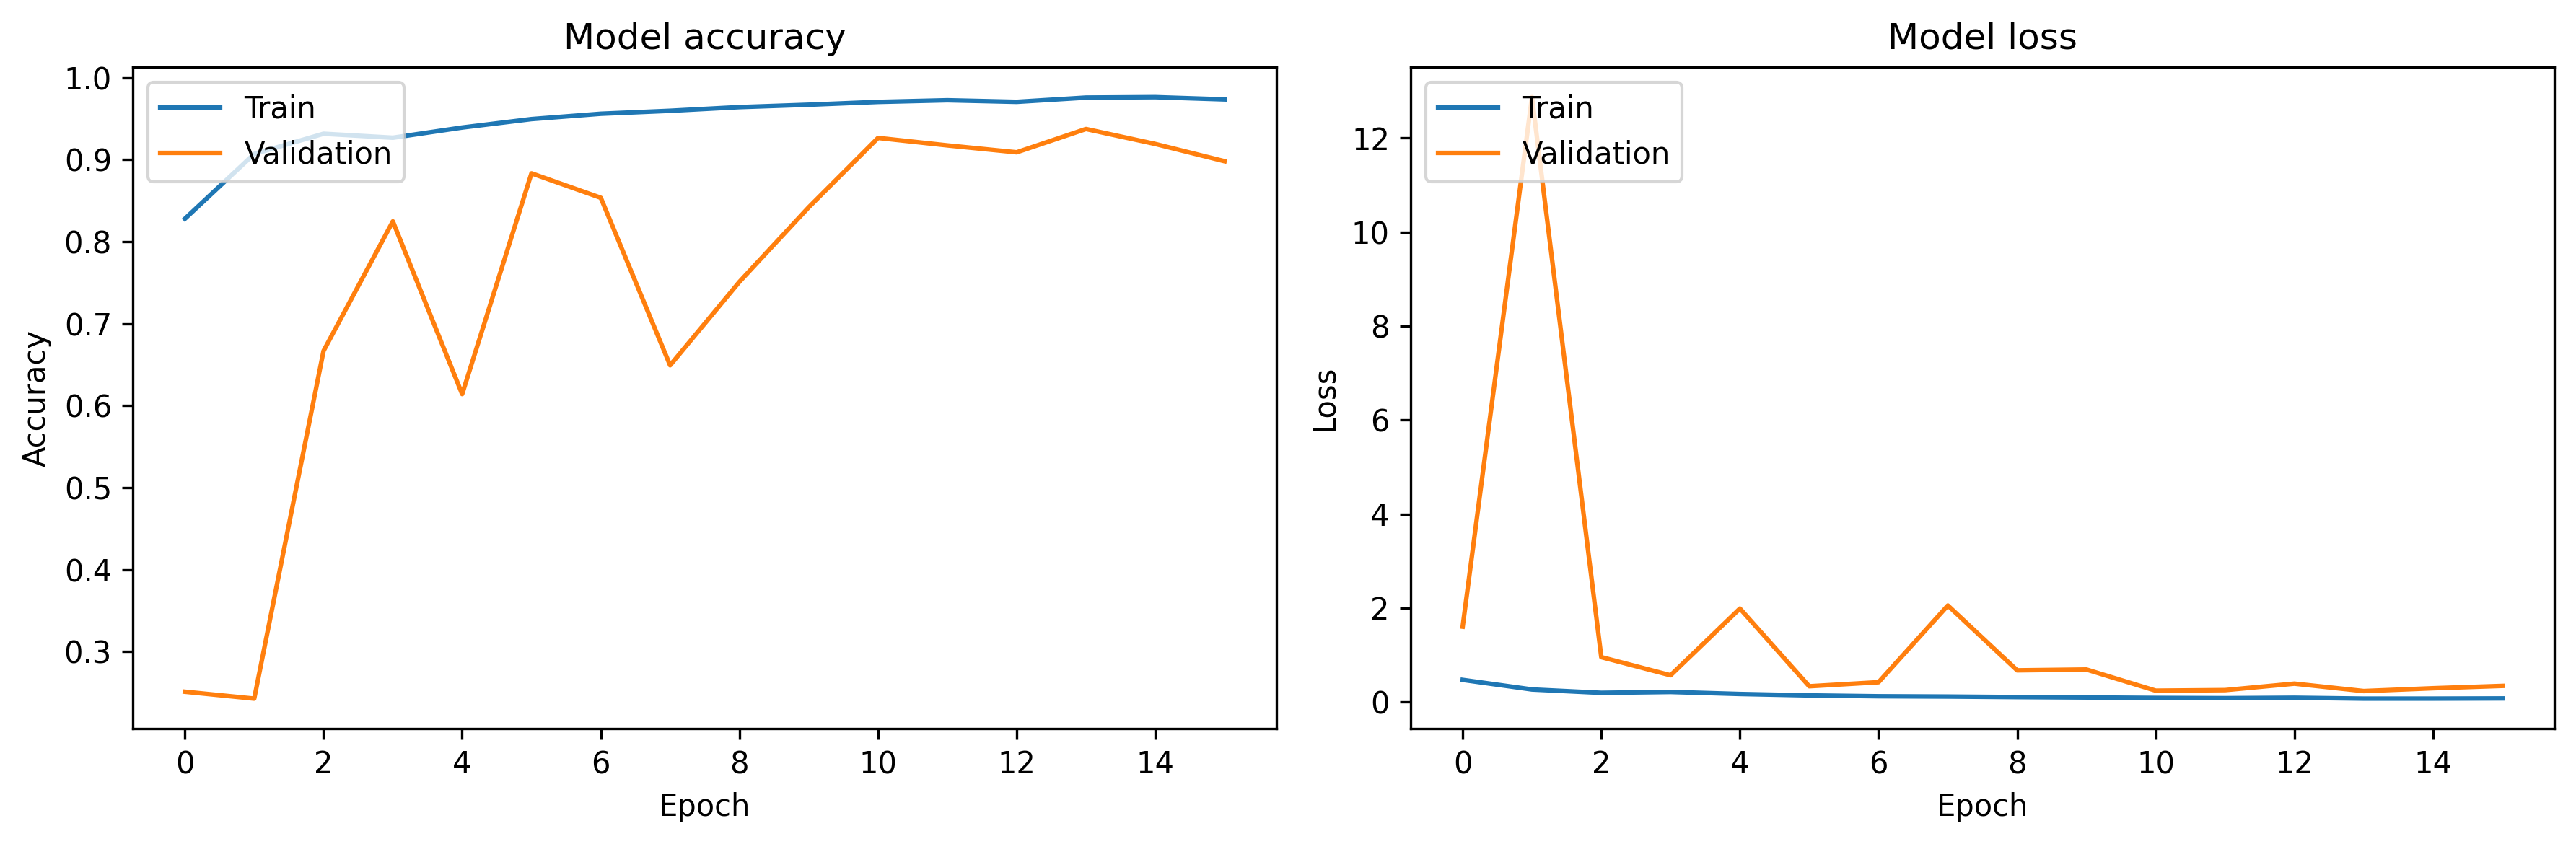

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4) ,dpi=300)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plots trainings & validations loss value
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

89/89 [==============================] - 6s 56ms/step


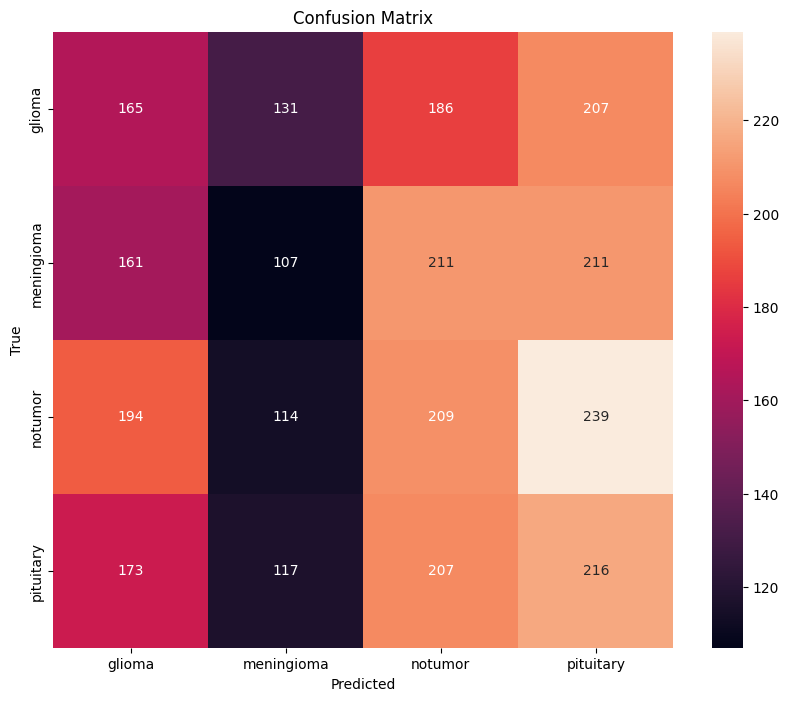

Classification Report
              precision    recall  f1-score   support

      glioma       0.24      0.24      0.24       689
  meningioma       0.23      0.16      0.18       690
     notumor       0.26      0.28      0.27       756
   pituitary       0.25      0.30      0.27       713

    accuracy                           0.24      2848
   macro avg       0.24      0.24      0.24      2848
weighted avg       0.24      0.24      0.24      2848



In [ ]:
import seaborn as sns
# Obtains true label and prediction
validation_generator.reset()
Y_pred = model.predict(validation_generator, validation_generator.n // batch + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Creates confusions matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plots confusions matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prints classifications report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [ ]:
images, labels = next(validation_generator)

In [ ]:
len(labels)

32

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 [==============================] - 0s 25ms/step


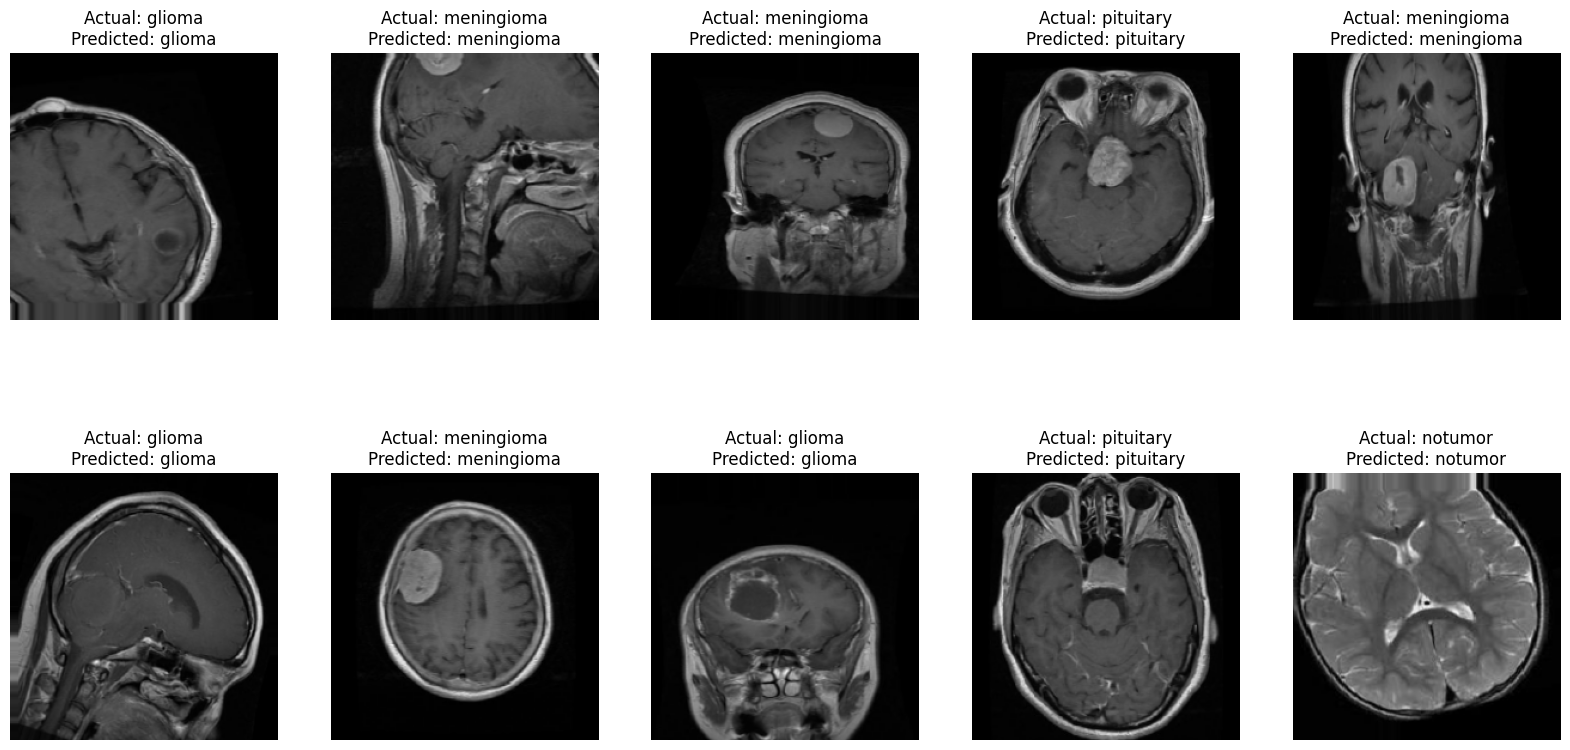

In [ ]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# Plots the image with their actual and predicteds class name
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

# Resnet101 Model evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101  # Import ResNet101 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_w, img_h = 224, 224  # Image dimensions expected by ResNet50
batch = 32
dataset_path = "/content/drive/MyDrive/Augmentation1/Augmentation"

In [ ]:
# Using rescales, shear_range, zoom_range, horizontal_flip for trainings data augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescales for validations data (no augmentations)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Trainings generators
train_generator = train_datagen.flow_from_directory(
   dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='training'  # Specifys this is for trainings set
)

# Validations generators
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation set
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [ ]:
num_classes = train_generator.num_classes
num_classes

4

In [ ]:

from tensorflow.keras.models import load_model

path = r"/content/drive/MyDrive/model_weights/Resnet101_Latest.h5"
model = load_model(path)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:

# Compiles the models agains (always after making any change)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [ ]:
images, labels = next(validation_generator)

In [ ]:
len(labels)

32

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
num_images =10
images, labels = next(validation_generator)
images = images[:num_images]
labels = labels[:num_images]

In [ ]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


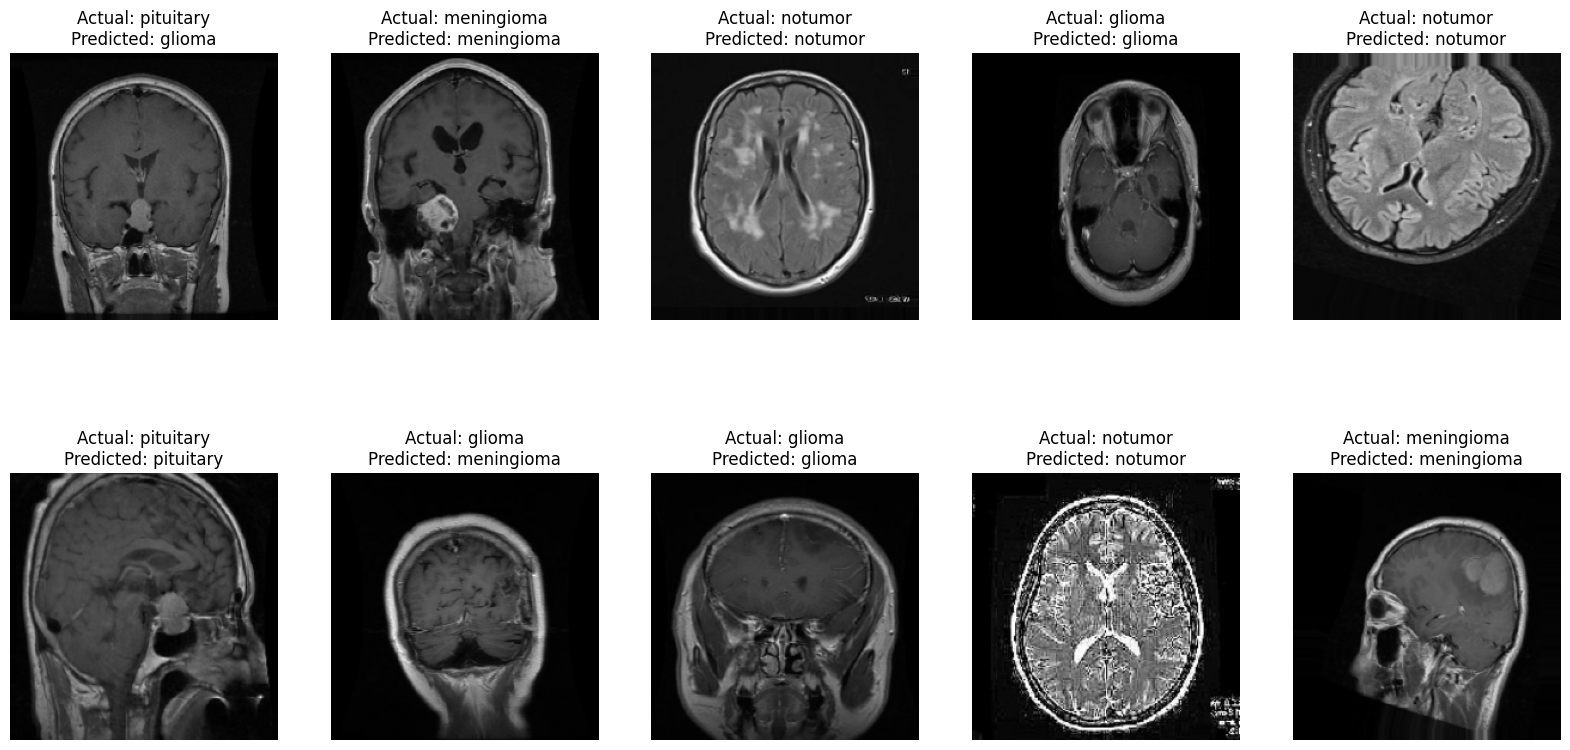

In [ ]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# Plots the image with their actual and predicteds class name
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

In [ ]:
images, labels = next(validation_generator)

In [ ]:
images= images[1,:,:,:]

In [ ]:
images.shape

(224, 224, 3)

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Loads the images
path = r"/content/drive/MyDrive/Augmentation1/Augmentation/glioma/Te-glTr_0000.jpg"
img = cv2.imread(path)
img = cv2.resize(img, (224, 224))

# Converts the images to a numpy arrays and normalize it
img = np.array(img) / 255.0

# Expands dimension to match the input shape expected by the model (batch, height, width, channels)
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)


predicted_label = np.argmax(predictions, axis=-1)
predicted_index = np.argmax(predictions, axis=-1)[0]
# Gets class indice from the generators
class_indices = validation_generator.class_indices


class_names = {v: k for k, v in class_indices.items()}

# Get the predicted class name
predicted_class = class_names[predicted_index]

print(f'Predicted Label Index: {predicted_index}')
print(f'Predicted Class Name: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Label Index: 0
Predicted Class Name: glioma
